In [60]:
# !pip uninstall matplotlib numpy pandas -y
# !pip install matplotlib numpy pandas

In [61]:
import matplotlib.pyplot as plt
from custom_scalar_formatter import CustomScalarFormatter
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import os

In [62]:
# Ignore runtime warnings
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [63]:
def load_results_opt(results_dir, dataset, opt, n_runs):
    results = {}

    optimizer = opt['optimizer']
    if 'precond' in list(opt.keys()):
        preconditioner = opt['precond']
        results_dir = os.path.join(results_dir, dataset, optimizer, preconditioner)
    else:
        results_dir = os.path.join(results_dir, dataset, optimizer)

    # Adjust n_runs for L-BFGS
    if optimizer in ['lbfgs', 'jacobi_pcg']:
        n_runs = 1

    for i in range(1, n_runs+1):
        results_dir_run = os.path.join(results_dir, 'run_' + str(i))
        filenames = os.listdir(results_dir_run)
        
        if optimizer in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha', 
                         'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
            for filename in filenames:
                if filename.endswith('.csv'):
                    if (filename.startswith(('lr', 'L', 's'))):
                        start = filename.find('_') + len('_')
                        end = filename.find('_seed_')
                        hyperparam = filename[start:end] # Get lr or L or s
                        if hyperparam not in list(results.keys()):
                            results[hyperparam] = []
                        
                        df = pd.read_csv(os.path.join(results_dir_run, filename))
                        results[hyperparam].append(df)
                    elif filename.startswith('auto'):
                        if 'auto' not in list(results.keys()):
                            results['auto'] = []

                        df = pd.read_csv(os.path.join(results_dir_run, filename))
                        results['auto'].append(df)
        elif optimizer in ['sketchysgd', 'lbfgs', 'jacobi_pcg']:
            for filename in filenames:
                if filename.endswith('.csv'):
                    if 'auto' not in list(results.keys()):
                        results['auto'] = []

                    df = pd.read_csv(os.path.join(results_dir_run, filename))
                    results['auto'].append(df)

    return results

In [64]:
def compute_median_quantiles(opt_results, q_lower = 0.1, q_upper = 0.9):
    median = {}
    ql = {}
    qu = {}
    for hyperparam in list(opt_results.keys()):
        median[hyperparam] = {}
        ql[hyperparam] = {}
        qu[hyperparam] = {}
        n = len(opt_results[hyperparam]) # Number of runs for a given hyperparameter
        data_cols = list(opt_results[hyperparam][0].columns[1:]) # Get column names
        n_data_rows = len(opt_results[hyperparam][0]) # Number of rows in the data
        # print('n_data_rows: ', n_data_rows)
        for metric in data_cols:
            if metric in ['times', 'train_loss', 'test_loss', 'train_acc', 'test_acc']: # Compute median for these metrics
                metric_data = np.zeros((n_data_rows, n))
                for i in range(n):
                    metric_data[:, i] = opt_results[hyperparam][i][metric].to_numpy()
                    metric_data[:, i] = np.nan_to_num(metric_data[:, i], nan = np.inf)
                if metric not in list(median[hyperparam].keys()):
                        median[hyperparam][metric] = np.median(metric_data, axis = 1)
                        ql[hyperparam][metric] = np.quantile(metric_data, q_lower, axis = 1)
                        qu[hyperparam][metric] = np.quantile(metric_data, q_upper, axis = 1)

    return {'median': median, 'ql': ql, 'qu': qu}


In [65]:
def get_best_median_run_opt(opt_medians, opt_name, metric):
    best_run = None
    best_hyperparam = None

    for hyperparam in list(opt_medians.keys()):
        if best_run is None:
            best_run = opt_medians[hyperparam]
            if opt_name in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha', 
                            'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
                best_hyperparam = hyperparam
        else:
            if 'loss' in metric:
                if np.min(opt_medians[hyperparam][metric]) < np.min(best_run[metric]):
                    best_run = opt_medians[hyperparam]
                    if opt_name in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha',
                                     'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
                        best_hyperparam = hyperparam
            elif 'acc' in metric:
                if np.max(opt_medians[hyperparam][metric]) > np.max(best_run[metric]):
                    best_run = opt_medians[hyperparam]
                    if opt_name in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha',
                                     'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
                        best_hyperparam = hyperparam
    
    return best_run, best_hyperparam

In [66]:
def get_median_run_min_hparam_opt(opt_medians):
    hyperparam_min = sorted(list(opt_medians.keys()))[0]
    min_hparam_run = opt_medians[hyperparam_min]

    return min_hparam_run, hyperparam_min

In [67]:
def get_median_qu_ql_results(results_dir, dataset, opts, n_runs, auto_only):
    median_results = {}
    ql_results = {}
    qu_results = {}
    for opt in opts:
        if isinstance(opt, tuple):
            opt_dict = {'optimizer': opt[0], 'precond': opt[1]}
        else:
            opt_dict = {'optimizer': opt}
        opt_results = load_results_opt(results_dir, dataset, opt_dict, n_runs)
        opt_m_q = compute_median_quantiles(opt_results)
        opt_medians = opt_m_q['median']
        opt_ql = opt_m_q['ql']
        opt_qu = opt_m_q['qu']
        if auto_only: # Only plot the auto hyperparameter results if requested
            if 'auto' in list(opt_medians.keys()): # If auto hyperparameter results exist, extract them
                opt_medians = {'auto': opt_medians['auto']}
                opt_ql = {'auto': opt_ql['auto']}
                opt_qu = {'auto': opt_qu['auto']}
                median_results[opt] = opt_medians
                ql_results[opt] = opt_ql
                qu_results[opt] = opt_qu
        else:
            if opt_dict['optimizer'] in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha', 
                                         'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg'] \
                and 'auto' in list(opt_medians.keys()): # If we do not care about auto results, remove them
                del opt_medians['auto']
                del opt_ql['auto']
                del opt_qu['auto']
            median_results[opt] = opt_medians
            ql_results[opt] = opt_ql
            qu_results[opt] = opt_qu

    return median_results, ql_results, qu_results

In [68]:
def get_opt_precond_name(opt):
    if isinstance(opt, tuple):
        opt_name = opt[0]
        precond_name = opt[1]
    else:
        opt_name = opt
        precond_name = None
    
    return opt_name, precond_name

In [69]:
def print_best_hyperparam(best_hyperparam, opt_name):
    best_hyperparam_str = str(best_hyperparam)
    if opt_name in ['sgd', 'svrg', 'saga', 'slbfgs']:
        print(f"{opt_name}: best LR = {best_hyperparam_str}")
    elif opt_name == 'lkatyusha':
        print(f"{opt_name}: best L = {best_hyperparam_str}")
    elif opt_name in ['rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
        print(f"{opt_name}: best s = {best_hyperparam_str}")

In [70]:
def get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names):
    if opt_name == 'sketchysgd':
        linestyle = 'dashed'
        marker = markers[precond_name]
        color = colors[(opt_name, precond_name)]
        label = f"{opt_plot_names[opt_name]} ({precond_plot_names[precond_name]})"
    else:
        linestyle = 'solid'
        marker = None
        color = colors[opt_name]
        label = opt_plot_names[opt_name]

    return linestyle, marker, color, label

In [71]:
def get_legend(results_keys, markers, colors, opt_plot_names, precond_plot_names):
    from matplotlib.lines import Line2D 
    legend_elements = []
    for opt in list(results_keys):
        opt_name, precond_name = get_opt_precond_name(opt)
        linestyle, marker, color, label = get_curve_params(opt_name, precond_name, markers, colors, opt_plot_names, precond_plot_names)
        legend_elements.append(Line2D([0], [0], color=color, label=label, linestyle = linestyle, marker = marker))
    return legend_elements

In [72]:
def plot_opt_curve(median_results, ql_results, qu_results, opt, key, best_hyperparam, xaxis, opt_name, metric, color,
                    linestyle, marker, axes):
    # If we are plotting something other than sketchysgd that does not correspond to the best hyperparameter, make it invisible
    if opt in ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha', 
                         'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg'] and key != best_hyperparam:
        alpha = 0
    else:
        alpha = 1

    if xaxis['name'] == 'time':
        x = np.cumsum(median_results[opt][key]['times'])
    elif xaxis['name'] == 'full_data_passes':
        x = np.arange(len(median_results[opt][key]['times'])) + 1
        if opt_name in ['svrg', 'lkatyusha', 'slbfgs']:
            x = 2*x

    if 'loss' in metric['name']:
        axes.semilogy(x, median_results[opt][key][metric['name']],
                        color, alpha = alpha, linestyle = linestyle, marker = marker, markevery = 10)
        axes.fill_between(x, ql_results[opt][key][metric['name']], qu_results[opt][key][metric['name']],
                            color = color, alpha = alpha*0.2)
    else:
        axes.plot(x, median_results[opt][key][metric['name']],
                    color, alpha = alpha, linestyle = linestyle, marker = marker, markevery = 10)
        axes.fill_between(x, ql_results[opt][key][metric['name']], qu_results[opt][key][metric['name']],
                            color = color, alpha = alpha*0.2)

In [73]:
def format_plot(dataset, ylims, xaxis, metric, opt_times_sorted, axes):
    axes.set_title(dataset, fontsize=14)
    axes.set_ylim(ylims)
    axes.tick_params(axis='both', which='major', labelsize=14)
    axes.tick_params(axis='both', which='minor', labelsize=10)
    axes.set_xlabel(xaxis['label'], fontsize=14)
    axes.set_ylabel(metric['label'], fontsize=14)

    if 'loss' in metric['name']:
        y_lower_bound, y_upper_bound = axes.get_ylim()
        axes.set_yticks([y_lower_bound, y_upper_bound])

        formatter = CustomScalarFormatter(useMathText=True, useOffset=False)
        formatter.set_scientific(True)
        formatter.set_powerlimits((0, 0))
        axes.yaxis.set_major_formatter(formatter)

        minor_ticks = np.linspace(y_lower_bound, y_upper_bound, num=10)
        minor_ticks = minor_ticks[1:-1]
        axes.set_yticks(minor_ticks, minor=True)
        # axes.yaxis.set_minor_formatter(formatter)
        axes.yaxis.set_minor_formatter(NullFormatter())

    if xaxis['name'] == 'time': # Truncate x-axis if plotting wall-clock time
        axes.set_xlim(0, opt_times_sorted[1])

In [74]:
def save(directory, fig_name, fig):
    plt.figure(fig)
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(os.path.join(directory, fig_name), bbox_inches='tight')

In [75]:
def plot_medians_metric(results_dir, dataset, opts, n_runs, metric, colors, opt_plot_names, 
                        precond_plot_names, markers, xaxis, ylims, auto_only, save_dir, save_plot = True):
    median_results, ql_results, qu_results = get_median_qu_ql_results(results_dir, dataset, opts, n_runs, auto_only)
            
    fig = plt.figure()
    axes = plt.gca()
    opt_times = np.zeros(len(list(median_results.keys())))
    legend_elements = get_legend(median_results.keys(), markers, colors, opt_plot_names, precond_plot_names)
    for i, opt in enumerate(list(median_results.keys())):
        opt_name, precond_name = get_opt_precond_name(opt)

        if opt_name in ['rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
            _, best_hyperparam = get_median_run_min_hparam_opt(median_results[opt])
        else:
            _, best_hyperparam = get_best_median_run_opt(median_results[opt], opt_name, metric['name'])
            print_best_hyperparam(best_hyperparam, opt_name)

        linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, 
                                                            colors, opt_plot_names, precond_plot_names)

        opt_time = np.inf
        for key in median_results[opt].keys():
            plot_opt_curve(median_results, ql_results, qu_results, opt, key, best_hyperparam, xaxis, 
                                      opt_name, metric, color, linestyle, marker, axes)

            # Get the smallest time taken by the optimization algorithm across all hyperparameters
            opt_time = min(opt_time, np.cumsum(median_results[opt][key]['times'])[-1])
        opt_times[i] = opt_time
    opt_times_sorted = np.sort(opt_times)

    axes.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=14)
    format_plot(dataset, ylims, xaxis, metric, opt_times_sorted, axes)

    if save_plot:
        opts_concat = '_'.join([opt[0] if isinstance(opt, tuple) else opt for opt in opts])
        fig_name = f"{dataset}_{opts_concat}_{xaxis['name']}.pdf"
        directory = './performance_'+ ('auto' if auto_only else 'tuned') + '/' + save_dir + '/' + metric['name']
        save(directory, fig_name, fig)

In [76]:
def plot_medians_metric_datasets_xaxes(results_dir, data_params, xaxes, opts, metric, colors, opt_plot_names, 
                                       precond_plot_names, markers, problem_type, save_dir, auto_only):
    # each element of data_params is dictionary with keys 'dataset', 'n_runs', 'ylims'
    # Create a grid of plots, one for each dataset and x-axis
    n_datasets = len(data_params)
    n_xaxes = len(xaxes)
    fig, axes = plt.subplots(nrows = n_xaxes, ncols = n_datasets, figsize = (n_datasets*4, n_xaxes*3))

    for i, data_param in enumerate(data_params):
        dataset = data_param['dataset']
        dataset_name = data_param['name']
        n_runs = data_param['n_runs']
        ylims = data_param['ylims']
        for j, xaxis in enumerate(xaxes):
                median_results, ql_results, qu_results = get_median_qu_ql_results(results_dir, dataset, opts, n_runs, auto_only)
                opt_times = np.zeros(len(list(median_results.keys())))
                if i == 0 and j == 0: # Only compute legend once
                    legend_elements = get_legend(median_results.keys(), markers, colors, opt_plot_names, precond_plot_names)
                for k, opt in enumerate(list(median_results.keys())):
                    opt_name, precond_name = get_opt_precond_name(opt)

                    if opt_name in ['rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg']:
                        _, best_hyperparam = get_median_run_min_hparam_opt(median_results[opt])
                    else:
                        _, best_hyperparam = get_best_median_run_opt(median_results[opt], opt_name, metric['name'])

                    linestyle, marker, color, _ = get_curve_params(opt_name, precond_name, markers, 
                                                                        colors, opt_plot_names, precond_plot_names)

                    opt_time = np.inf
                    for key in median_results[opt].keys():
                        plot_opt_curve(median_results, ql_results, qu_results, opt, key, best_hyperparam, xaxis, 
                                                  opt_name, metric, color, linestyle, marker, axes[j, i])

                        # Get the smallest time taken by the optimization algorithm across all hyperparameters
                        opt_time = min(opt_time, np.cumsum(median_results[opt][key]['times'])[-1])
                    opt_times[k] = opt_time
                opt_times_sorted = np.sort(opt_times)
                format_plot(dataset_name, ylims, xaxis, metric, opt_times_sorted, axes[j, i])
    
    for ax in axes.flat:
        ax.set_ylabel('') # Turn off y-labels for subplots
    # plt.ylabel(metric['label'], fontsize = 12)
    fig.text(0, 0.5, metric['label'], va='center', rotation='vertical', fontsize=14)


    fig.tight_layout(pad=2.0)
    # fig.subplots_adjust(hspace=0.45, wspace=0.4)

    # Add legend to the bottom of the grid
    fig.legend(handles = legend_elements, loc='upper center', bbox_to_anchor=(0.5, 0.00), ncol=3, fontsize=14)

    # Save plot
    opts_concat = '_'.join([opt[0] if isinstance(opt, tuple) else opt for opt in opts])
    directory = './performance_'+ ('auto' if auto_only else 'tuned') + '/' + save_dir + '/' + metric['name']
    fig_name = f'combined_{opts_concat}_{problem_type}.pdf'
    save(directory, fig_name, fig)

In [77]:
results_dir = '../simods_performance_results_dup2'
save_dir = 'dup2'
opts_ls = ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha', 
        'lbfgs', 'rsn', 'nsketch', 'nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg',
        ('sketchysgd', 'nystrom'), ('sketchysgd', 'ssn')]
opts_log = ['sgd', 'svrg', 'saga', 'slbfgs', 'lkatyusha',
            'lbfgs', 'rsn', 'nsketch',
            ('sketchysgd', 'nystrom'), ('sketchysgd', 'ssn')]
opts_fo = ['sgd', 'svrg', 'saga', 'lkatyusha']
opts_qn = ['lbfgs', 'slbfgs', 'rsn', 'nsketch']
opts_pcg = ['nystrom_pcg', 'gauss_sp_pcg', 'sparse_sp_pcg', 'jacobi_pcg']
opts_sketchy = [('sketchysgd', 'nystrom'), ('sketchysgd', 'ssn')]
opts_auto = ['svrg', 'saga', 'lkatyusha', ('sketchysgd', 'nystrom'), ('sketchysgd', 'ssn')]
metrics = [{'name': 'train_loss', 'label': 'Training Loss'},
        {'name': 'test_loss', 'label': 'Test Loss'},
        {'name': 'train_acc', 'label': 'Training Accuracy (\%)'},
        {'name': 'test_acc', 'label': 'Test Accuracy (\%)'}]
colors = {'sgd': 'tab:red', 'svrg': 'tab:blue', 'saga': 'tab:orange', 'lkatyusha': 'tab:pink',
          'slbfgs': 'tab:brown', 'lbfgs': 'k', 'rsn': 'tab:red', 'nsketch': 'tab:blue', 
          'nystrom_pcg': 'tab:red', 'gauss_sp_pcg': 'tab:blue', 'sparse_sp_pcg': 'tab:orange', 'jacobi_pcg': 'tab:pink',
          ('sketchysgd', 'nystrom'): 'tab:green', ('sketchysgd', 'ssn'): 'tab:purple'}
opt_plot_names = {'sgd': 'SGD', 'svrg': 'SVRG', 'saga': 'SAGA', 'lkatyusha': 'L-Katyusha',
                  'slbfgs': 'SLBFGS', 'lbfgs': 'L-BFGS', 'rsn': 'RSN', 'nsketch': 'Newton Sketch', 
                  'nystrom_pcg': r'Nystr$\ddot{\mathrm{o}}$mPCG', 'gauss_sp_pcg': 'GaussPCG', 'sparse_sp_pcg': 'SparsePCG', 'jacobi_pcg': 'JacobiPCG',
                  'sketchysgd': 'SketchySGD'}
precond_plot_names = {'nystrom': r'Nystr$\ddot{\mathrm{o}}$m', 'ssn': 'SSN'}
markers = {'nystrom': '^', 'ssn': '*'}
xaxes = [{'name': 'time', 'label': 'Wall-clock time (s)'}, {'name': 'full_data_passes', 'label': 'Full gradient evaluations'}]

In [78]:
# Render plots in LaTeX
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif')

### All tuned

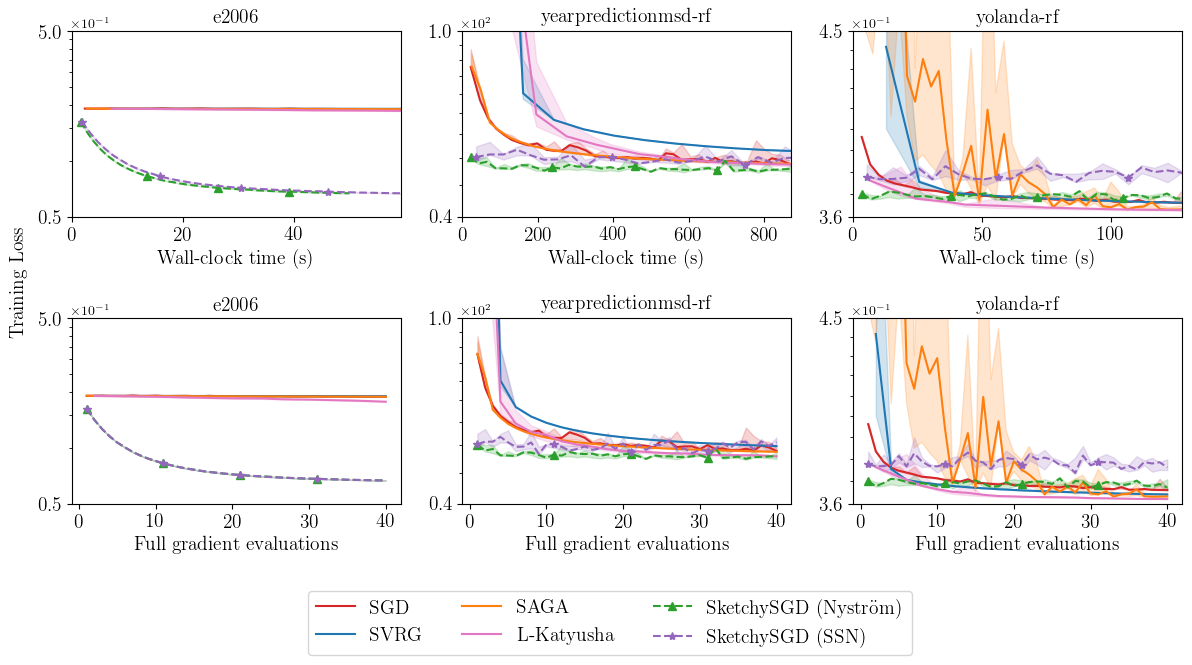

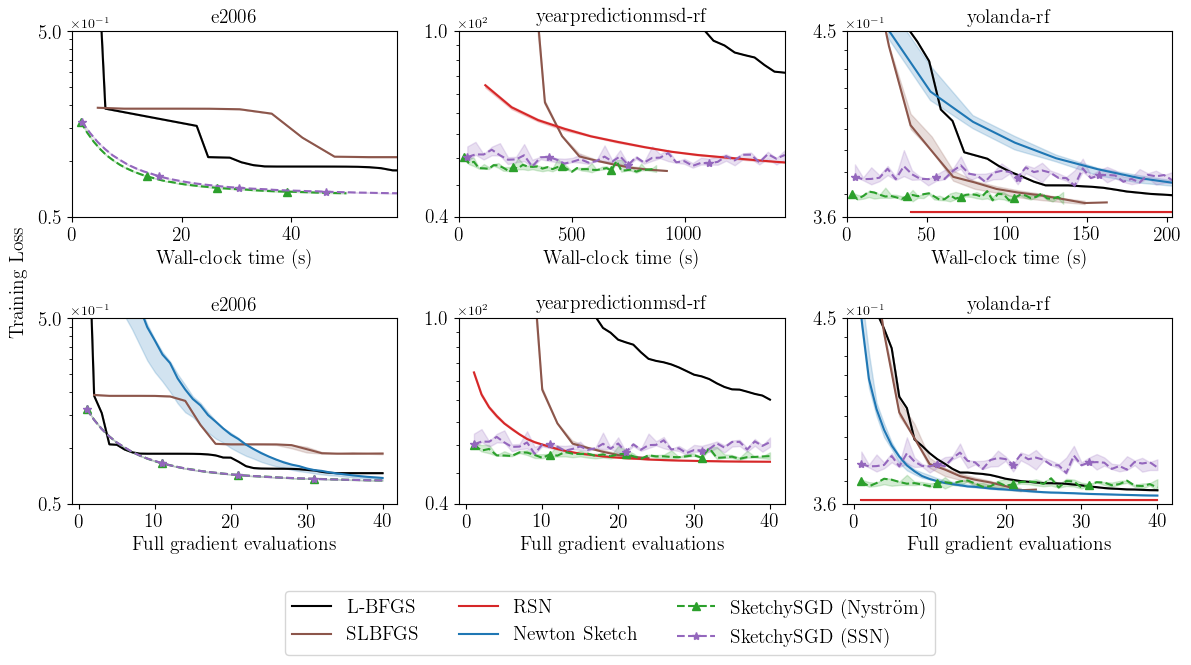

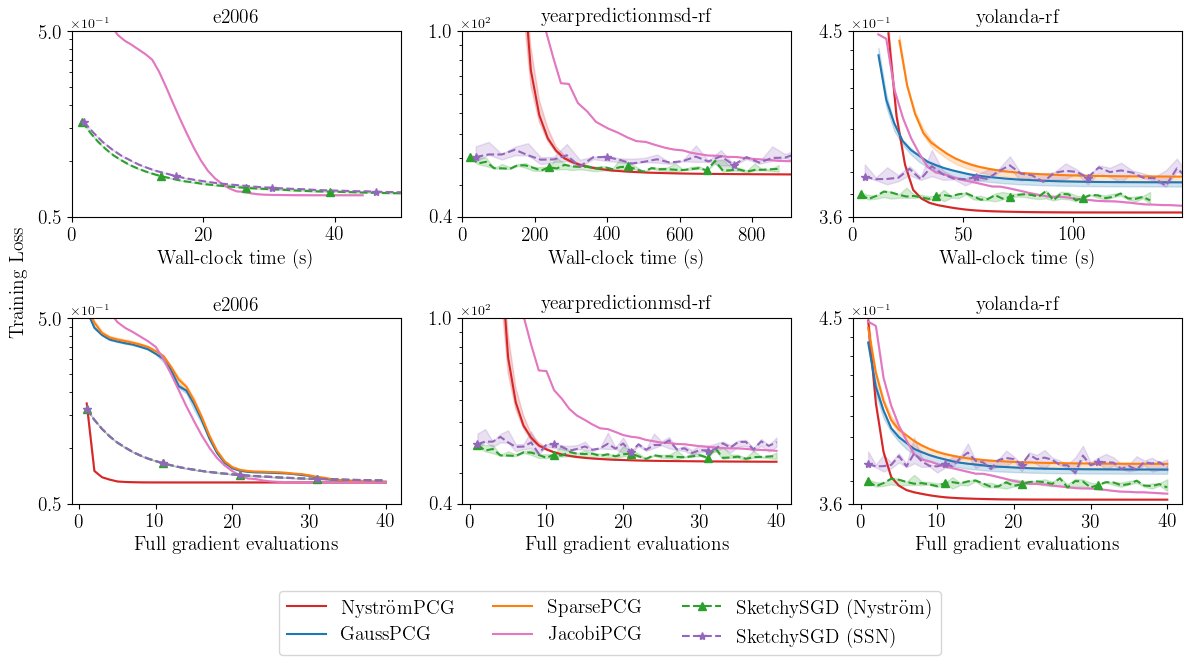

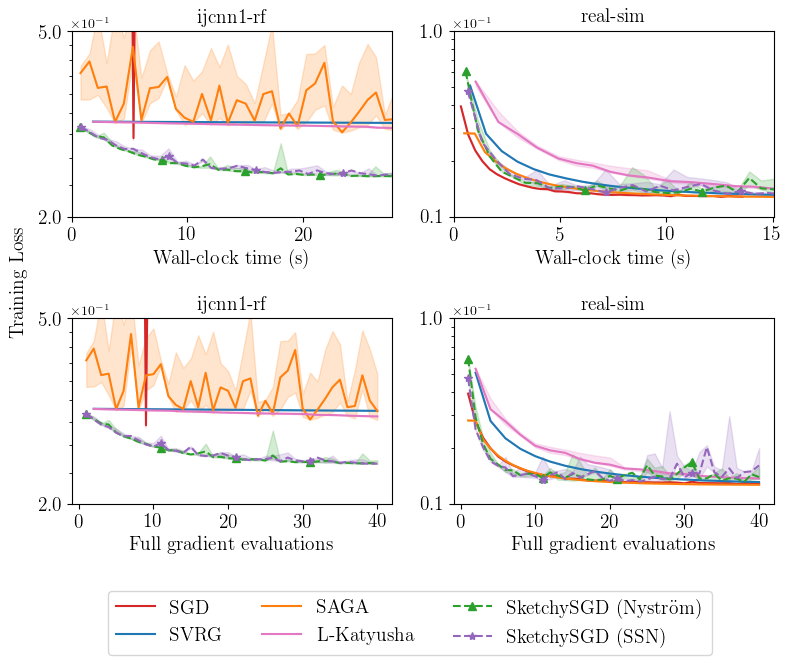

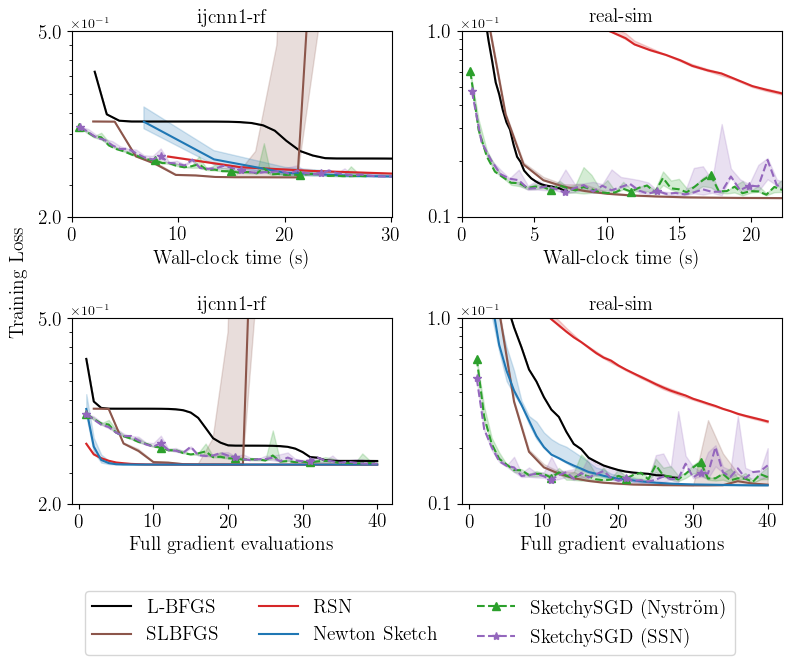

In [79]:
# data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 10, 'ylims': [1.4e-1, 2.2e-1]},
#                 {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 10, 'ylims': [5e1, 1e2]},
#                 {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 10, 'ylims': [3.6e-1, 4.5e-1]}]
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [2.5e-1, 4e-1]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [2e-2, 9e-2]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [4.4e-1, 6e-1]}]

data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 3, 'ylims': [0.5e-1, 5e-1]},
                {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 3, 'ylims': [4e1, 1e2]},
                {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 3, 'ylims': [3.6e-1, 4.5e-1]}]
data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [2e-1, 5e-1]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 3, 'ylims': [1e-2, 10e-2]}]

# Training loss
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_fo+opts_sketchy, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_qn+opts_sketchy, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_pcg+opts_sketchy, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_fo+opts_sketchy, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_qn+opts_sketchy, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)

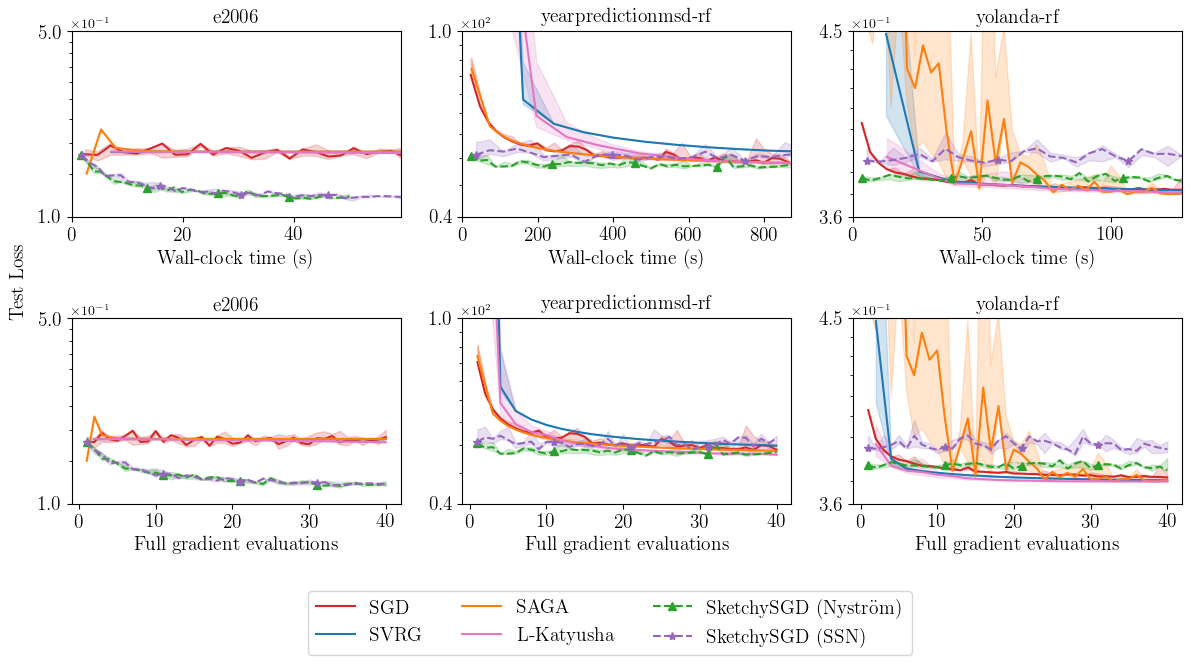

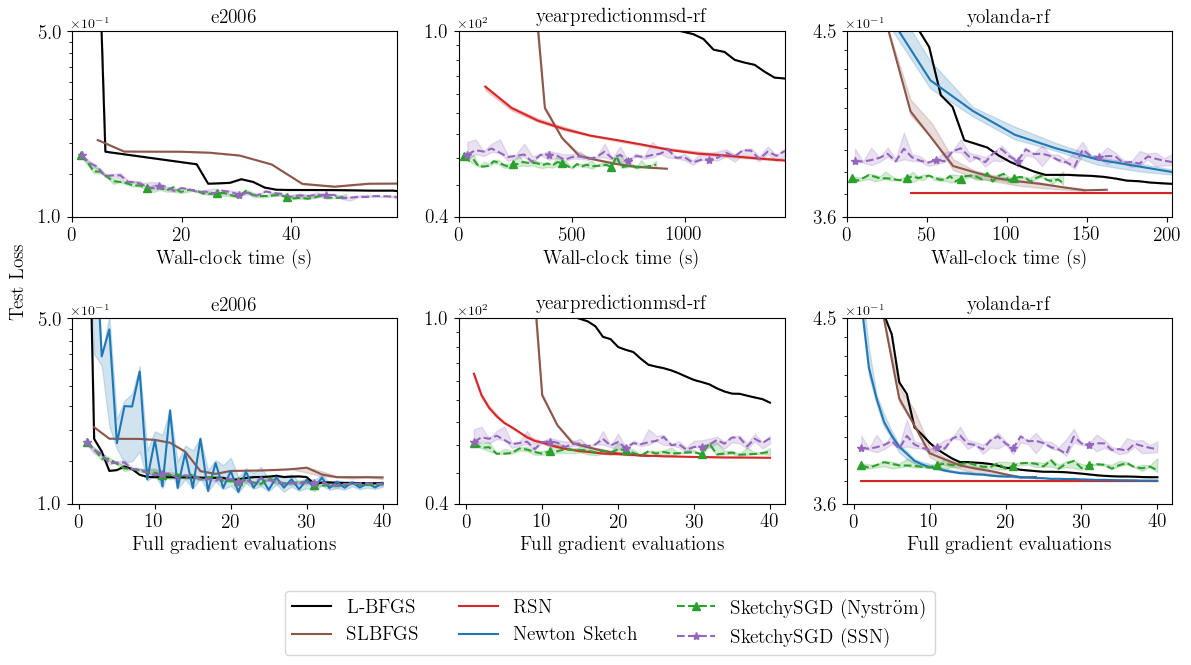

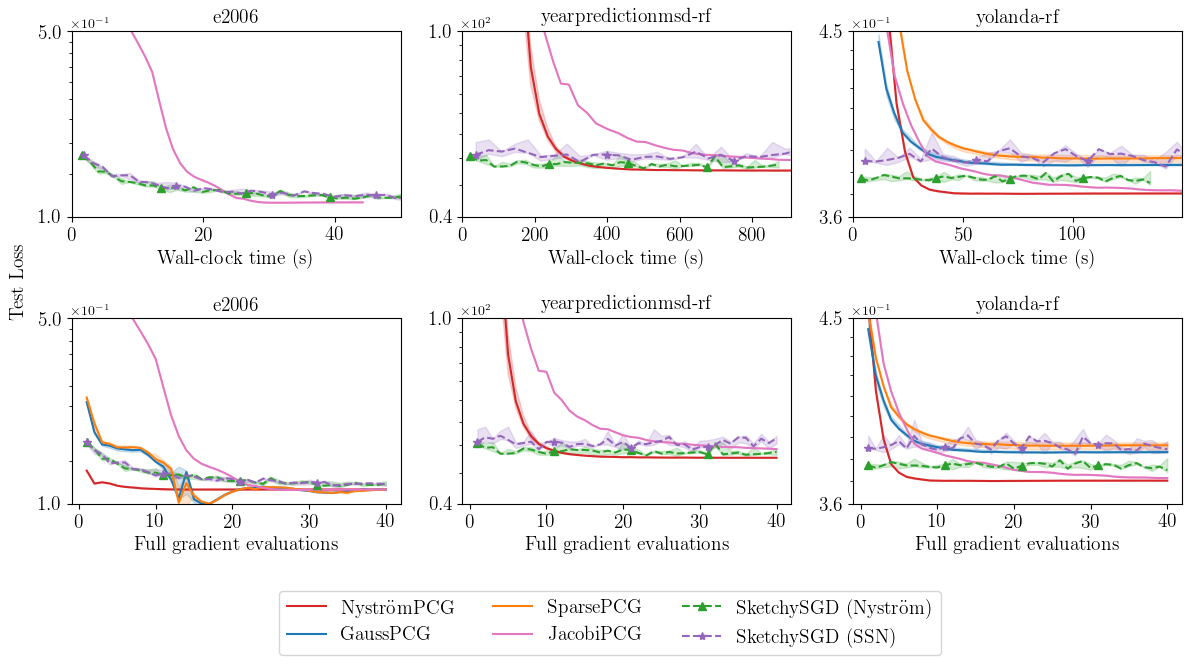

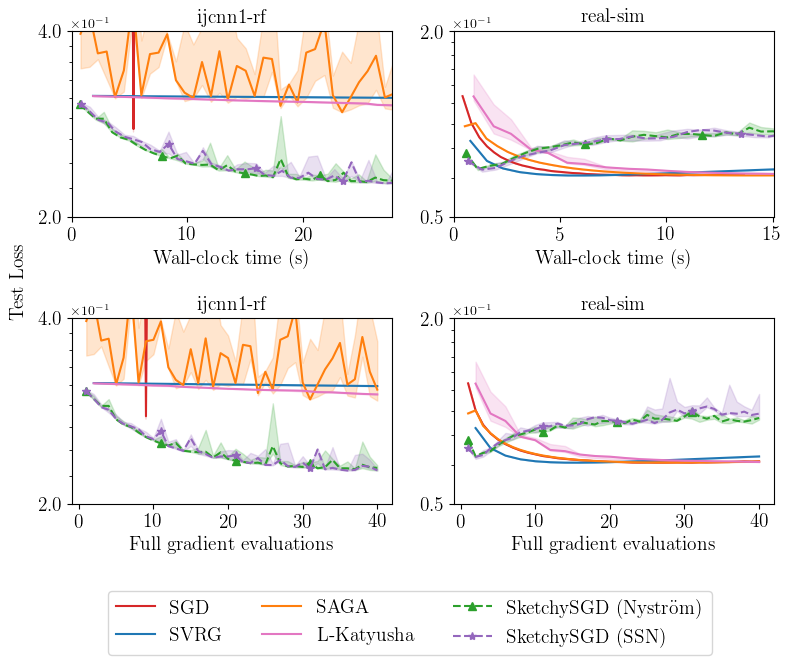

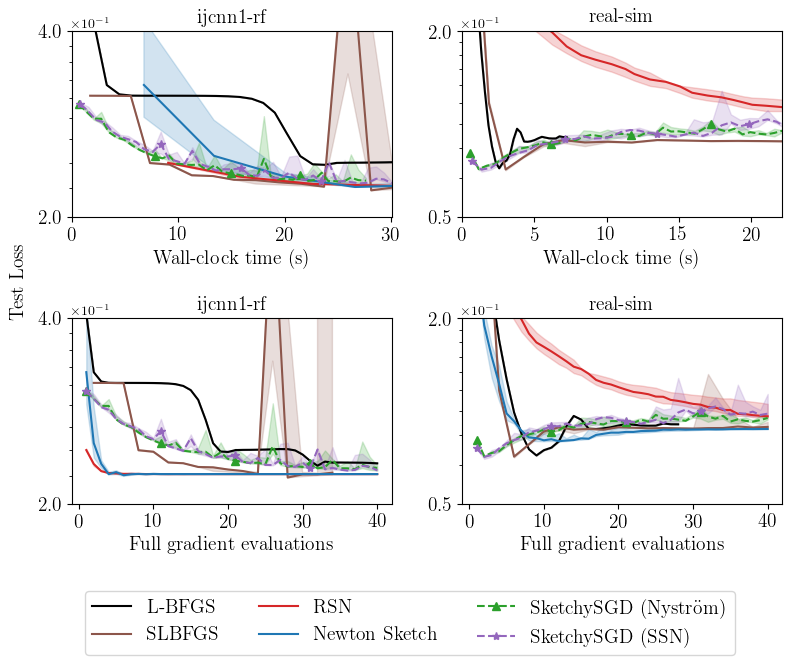

In [80]:
# data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 10, 'ylims': [1.2e-1, 2.2e-1]},
#                {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 10, 'ylims': [5e1, 1e2]},
#                {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 10, 'ylims': [3.6e-1, 4.5e-1]}]
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [2e-1, 4e-1]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [6e-2, 14e-2]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [4.4e-1, 6e-1]}]

data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 3, 'ylims': [1e-1, 5e-1]},
                {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 3, 'ylims': [4e1, 1e2]},
                {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 3, 'ylims': [3.6e-1, 4.5e-1]}]
data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [2e-1, 4e-1]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 3, 'ylims': [5e-2, 20e-2]}]


# Test loss
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_fo+opts_sketchy, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_qn+opts_sketchy, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_pcg+opts_sketchy, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_fo+opts_sketchy, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_qn+opts_sketchy, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)

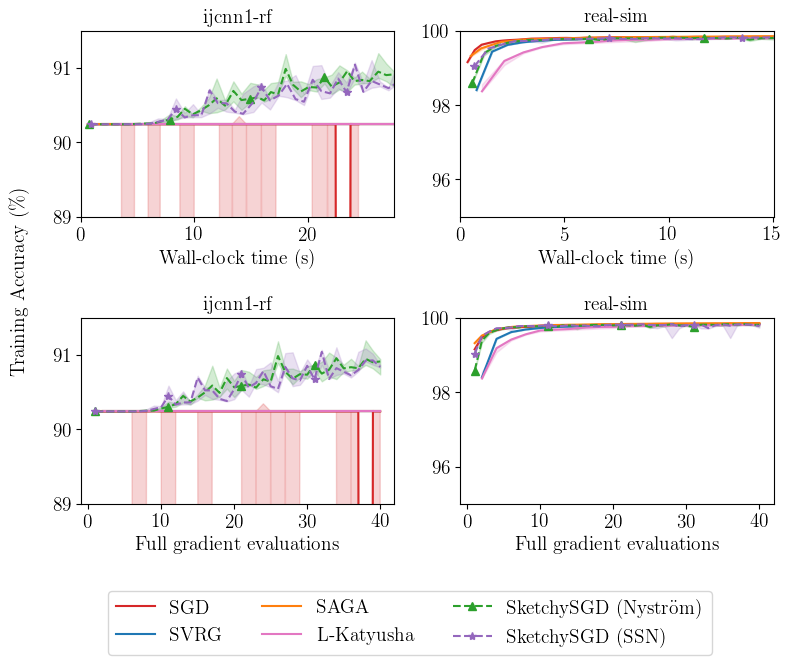

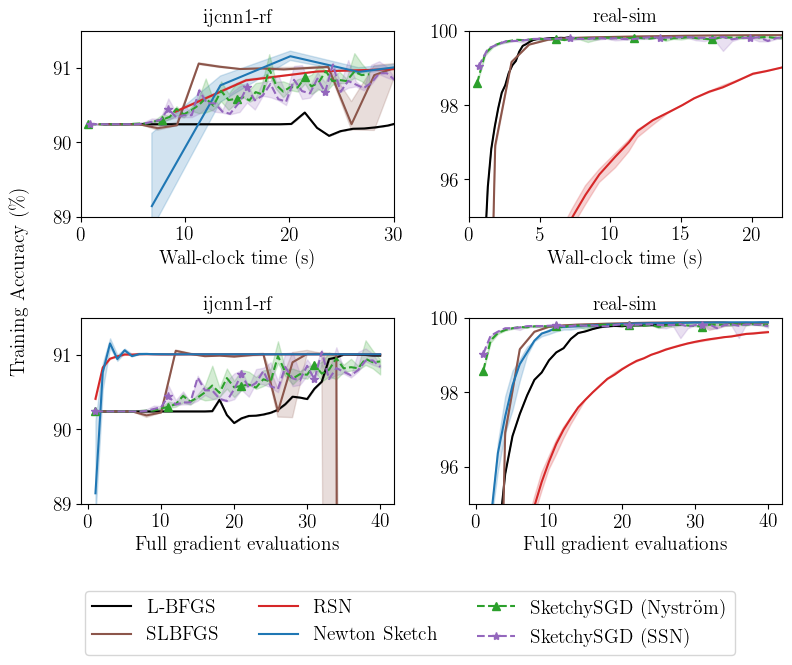

In [81]:
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [89, 91]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [95, 100]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [70, 80]}]

data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [89, 91.5]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 3, 'ylims': [95, 100]}]

# Training accuracy
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_fo+opts_sketchy, metrics[2], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_qn+opts_sketchy, metrics[2], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)
# plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts, metrics[2], colors,
#                                     opt_plot_names, precond_plot_names, markers, 'logistic', auto_only = False)

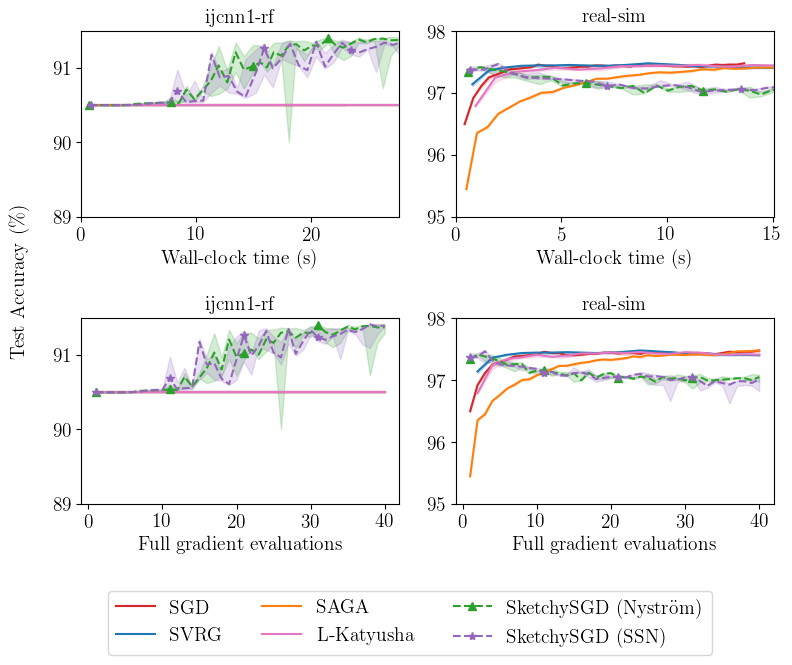

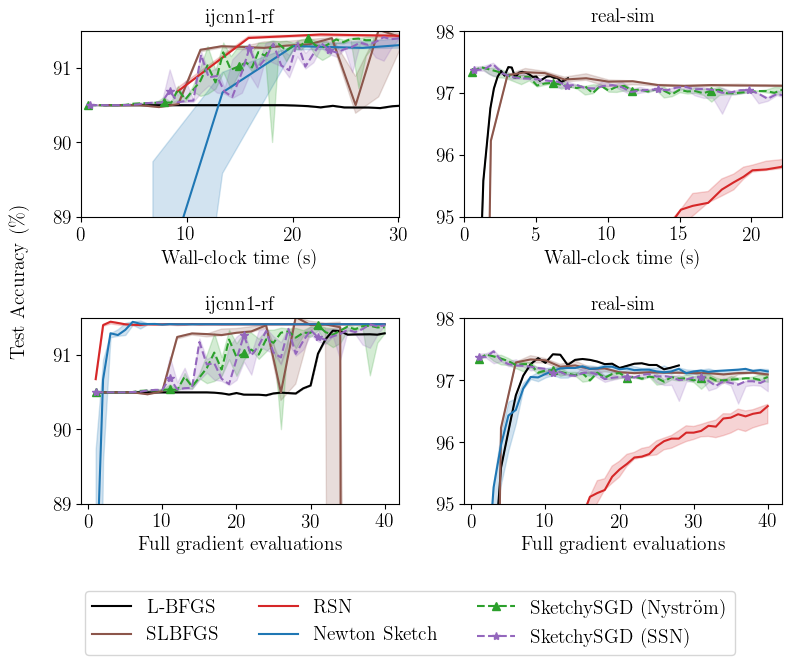

In [82]:
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [89, 91]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [95, 98]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [70, 80]}]

data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [89, 91.5]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 3, 'ylims': [95, 98]}]

# Test accuracy
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_fo+opts_sketchy, metrics[3], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_qn+opts_sketchy, metrics[3], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = False)
# plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts, metrics[3], colors,
#                                     opt_plot_names, precond_plot_names, markers, 'logistic', auto_only = False)

### All auto

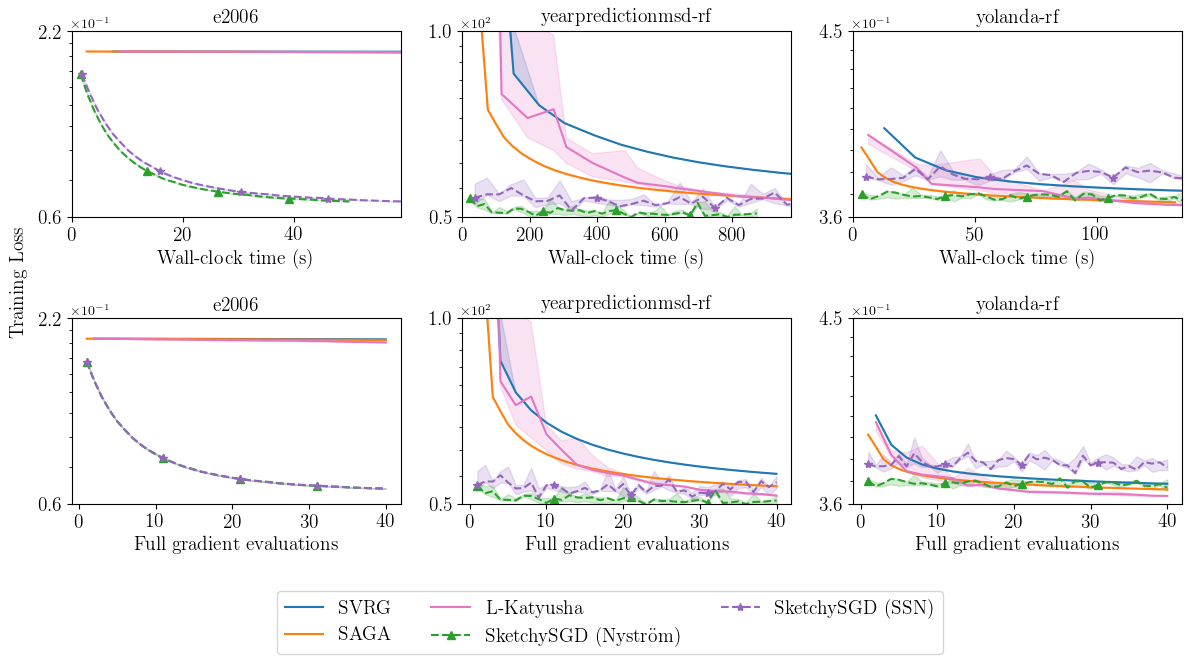

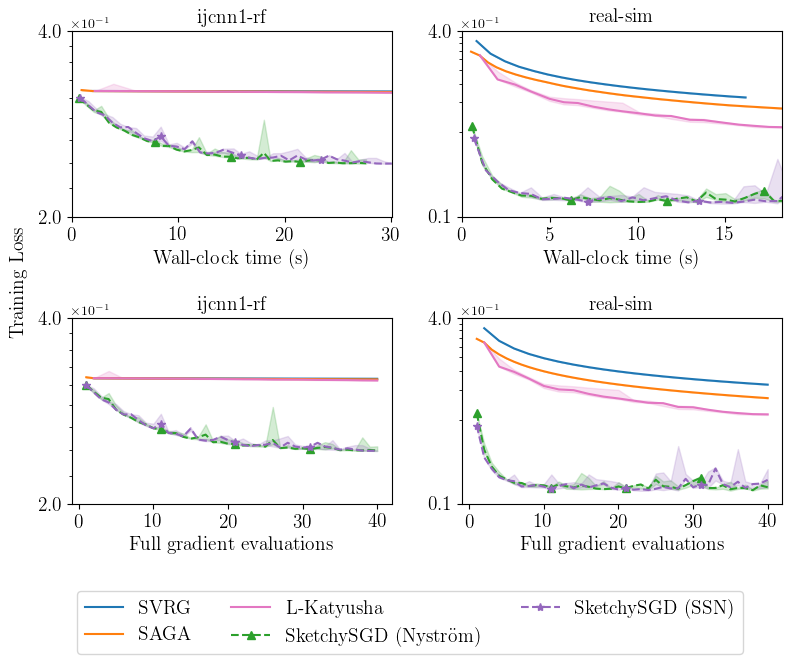

In [83]:
# data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 10, 'ylims': [1.4e-1, 2.2e-1]},
#                {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 10, 'ylims': [5e1, 1e2]},
#                {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 10, 'ylims': [3.6e-1, 4.5e-1]}]
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [2.5e-1, 4e-1]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [2e-2, 40e-2]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [4.4e-1, 6e-1]}]

data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 3, 'ylims': [0.6e-1, 2.2e-1]},
               {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 3, 'ylims': [5e1, 1e2]},
               {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 3, 'ylims': [3.6e-1, 4.5e-1]}]
data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [2e-1, 4e-1]},
               {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 3, 'ylims': [1e-2, 40e-2]}]

# Training loss
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_auto, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = True)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_auto, metrics[0], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = True)

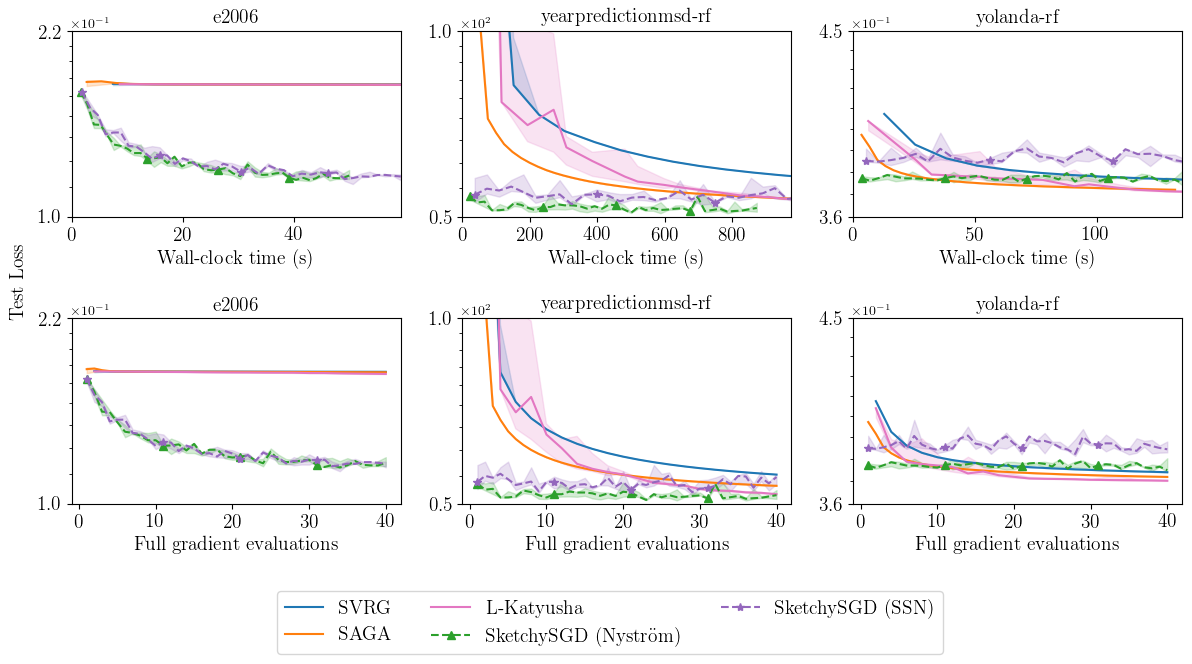

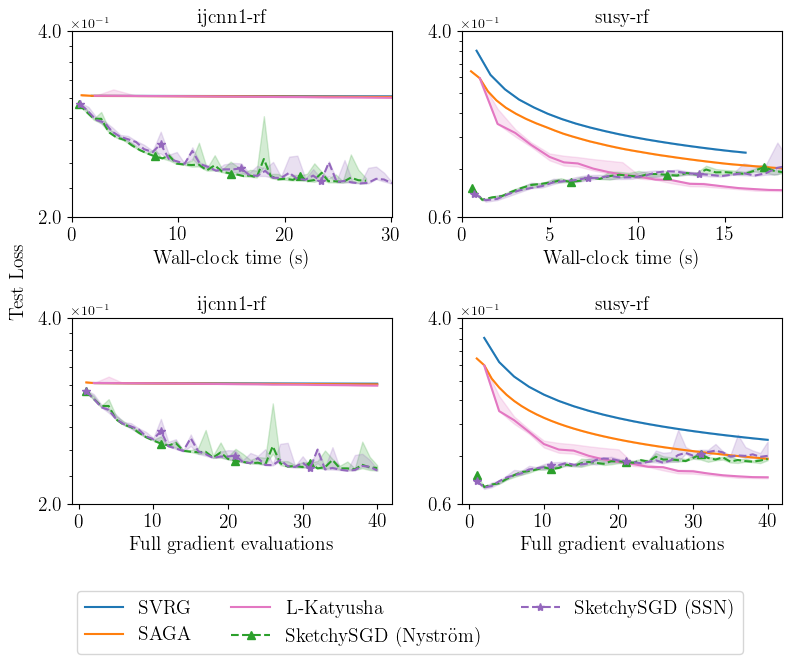

In [84]:
# data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 10, 'ylims': [1.2e-1, 2.2e-1]},
#                {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 10, 'ylims': [5e1, 1e2]},
#                {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 10, 'ylims': [3.6e-1, 4.5e-1]}]
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [2e-1, 4e-1]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [6e-2, 40e-2]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [4.4e-1, 6e-1]}]

data_params_least_squares = [{'dataset': 'e2006', 'name': 'e2006', 'n_runs': 3, 'ylims': [1e-1, 2.2e-1]},
               {'dataset': 'yearpredictionmsd', 'name': 'yearpredictionmsd-rf', 'n_runs': 3, 'ylims': [5e1, 1e2]},
               {'dataset': 'yolanda', 'name': 'yolanda-rf', 'n_runs': 3, 'ylims': [3.6e-1, 4.5e-1]}]
data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [2e-1, 4e-1]},
               {'dataset': 'real-sim', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [6e-2, 40e-2]}]

# Test loss
plot_medians_metric_datasets_xaxes(results_dir, data_params_least_squares, xaxes, opts_auto, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'least_squares', save_dir, auto_only = True)
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_auto, metrics[1], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = True)

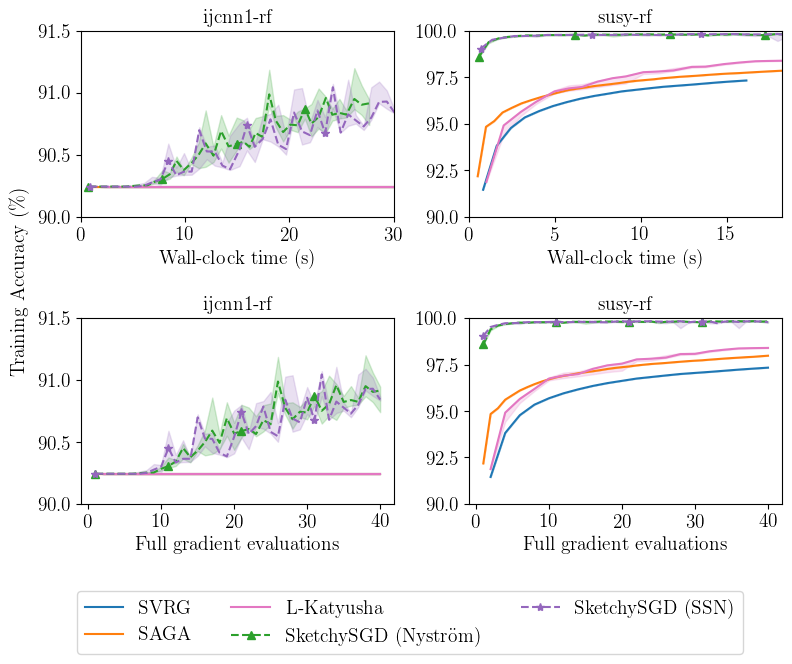

In [85]:
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [90, 90.5]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [90, 100]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [70, 80]}]

data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [90, 91.5]},
               {'dataset': 'real-sim', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [90, 100]}]

# Training accuracy
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_auto, metrics[2], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = True)

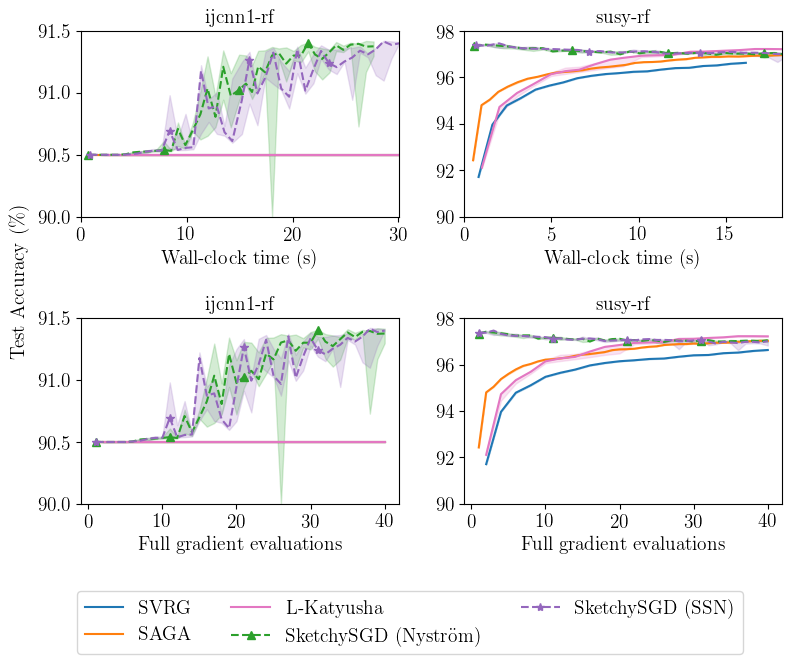

In [86]:
# data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 10, 'ylims': [90.2, 90.7]},
#                {'dataset': 'real-sim', 'name': 'real-sim', 'n_runs': 10, 'ylims': [90, 98]},
#                {'dataset': 'susy', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [70, 80]}]

data_params_logistic = [{'dataset': 'ijcnn1', 'name': 'ijcnn1-rf', 'n_runs': 3, 'ylims': [90, 91.5]},
               {'dataset': 'real-sim', 'name': 'susy-rf', 'n_runs': 3, 'ylims': [90, 98]}]

# Test accuracy
plot_medians_metric_datasets_xaxes(results_dir, data_params_logistic, xaxes, opts_auto, metrics[3], colors,
                                    opt_plot_names, precond_plot_names, markers, 'logistic', save_dir, auto_only = True)

### ijcnn1

In [47]:
# dataset = 'ijcnn1'
# n_runs = 10
# ylims = [2.5e-1, 4e-1] 
# # ylims = [80, 95]
# auto_only = False
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### ijcnn1 - auto

In [48]:
# dataset = 'ijcnn1'
# n_runs = 10
# ylims = [2.5e-1, 4e-1] 
# # ylims = [80, 95]
# auto_only = True
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### real-sim

In [49]:
# dataset = 'real-sim'
# n_runs = 10
# ylims = [2e-2, 4e-2] 
# # ylims = [95, 100]
# auto_only = False
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### real-sim - auto

In [50]:
# dataset = 'real-sim'
# n_runs = 10
# ylims = [2e-2, 40e-2] 
# # ylims = [95, 100]
# auto_only = True
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### susy

In [51]:
# dataset = 'susy'
# n_runs = 3
# ylims = [4.4e-1, 6e-1] 
# # ylims = [70, 80]
# auto_only = False
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### susy - auto

In [52]:
# dataset = 'susy'
# n_runs = 3
# ylims = [4.4e-1, 6e-1] 
# # ylims = [70, 80]
# auto_only = True
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### e2006

In [53]:
dataset = 'e2006'
n_runs = 10
ylims = [1.4e-1, 2.2e-1] 
auto_only = False
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

sgd: best LR = 0.5994842503189413
svrg: best LR = 0.5994842503189413
saga: best LR = 0.5994842503189413
lkatyusha: best L = 0.21544346900318834
sgd: best LR = 0.5994842503189413
svrg: best LR = 0.5994842503189413
saga: best LR = 0.5994842503189413
lkatyusha: best L = 0.21544346900318834


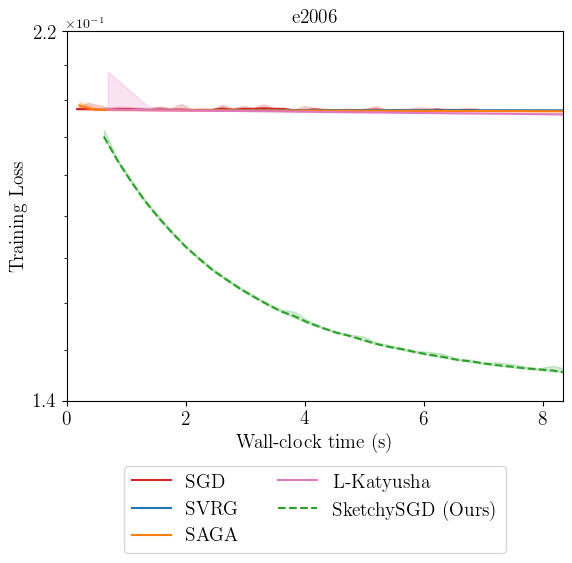

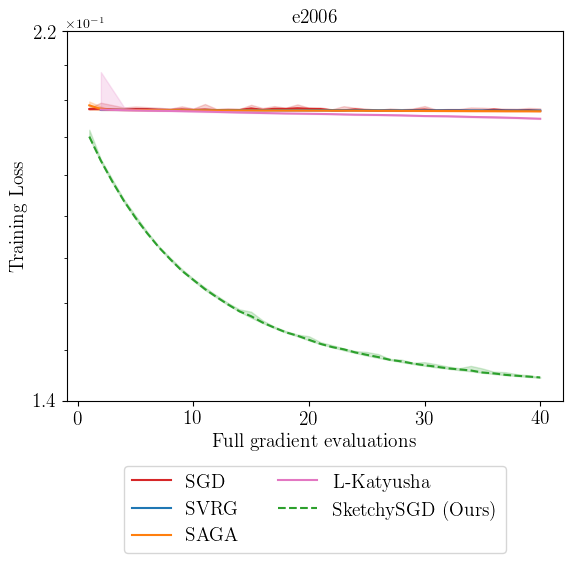

In [54]:
opts_new = ['sgd', 'svrg', 'saga', 'lkatyusha', ('sketchysgd', 'nystrom')]
precond_plot_names_new = {'nystrom': 'Ours'}
markers_new = {'nystrom': None}

plot_medians_metric(results_dir, dataset, opts_new, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names_new, markers_new, xaxes[0], ylims, auto_only, save_dir, save_plot = False)
plt.savefig(f'./performance_tuned/{save_dir}/train_loss/e2006_time_intro.pdf', bbox_inches='tight')

plot_medians_metric(results_dir, dataset, opts_new, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names_new, markers_new, xaxes[1], ylims, auto_only, save_dir, save_plot = False)
plt.savefig(f'./performance_tuned/{save_dir}/train_loss/e2006_full_data_passes_intro.pdf', bbox_inches='tight')

### e2006 - auto

In [55]:
# dataset = 'e2006'
# n_runs = 10
# ylims = [1.4e-1, 2.2e-1] 
# auto_only = True
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### yearpredictionmsd

In [56]:
# dataset = 'yearpredictionmsd'
# n_runs = 10
# ylims = [5e1, 1e2]
# auto_only = False
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### yearpredictionmsd - auto

In [57]:
# dataset = 'yearpredictionmsd'
# n_runs = 10
# ylims = [5e1, 1e2] 
# auto_only = True
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### yolanda

In [58]:
# dataset = 'yolanda'
# n_runs = 10
# ylims = [3.6e-1, 4.5e-1] 
# auto_only = False
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)

### yolanda - auto

In [59]:
# dataset = 'yolanda'
# n_runs = 10
# ylims = [3.6e-1, 4.5e-1] 
# auto_only = True
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[0], ylims, auto_only)
# plot_medians_metric(results_dir, dataset, opts, n_runs, metrics[0], colors, opt_plot_names, precond_plot_names, markers, xaxes[1], ylims, auto_only)